In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision.models.vgg import VGG
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.misc
import random
import sys

import torchvision
import torchvision.transforms as transforms

if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2

from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import numpy as np
import time
import os

import gdown

In [2]:
def check_and_create_folder(directory):
    try:
        os.stat(directory)
        print ('folder: ', directory, 'exits, do you want to remove it')
    except:
        os.mkdir(directory)
        print ('create ', directory)

## Define FCN16s model for deconvolution layers

In [3]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super(FCN16s, self).__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace = True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

## Define VGG16 for convolution layers

In [4]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super(VGGNet, self).__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):      
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x
        return output

In [5]:
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

## Define training parameter

In [28]:
batch_size = 6
epochs     = 400
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 50
gamma      = 0.5
model_use  = "electronics"#"mini_competition" # "products_20" "mini_competition"
data_path = "./electronics_train"
#data_path = "/root/sis_lab_all/12-1_Pytorch-FCN/data/mini_competition/"
n_class = 6


## Define path, directory trainning environment

In [29]:
# get data
data_dir  = os.path.join(data_path)
if not os.path.exists(data_dir):
    print("Data not found!")
# create dir for model
model_dir = os.path.join(data_path, "models")
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# create dir for score
score_dir = os.path.join(data_path, "scores")
if not os.path.exists(score_dir):
    os.makedirs(score_dir)
# create dir for ele_test
ele_test_dir = os.path.join(data_path, "ele_test")
if not os.path.exists(ele_test_dir):
    os.makedirs(ele_test_dir)
    
use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)
#use_gpu = False
if use_gpu:
    ts = time.time()
    vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))

Finish cuda loading, time elapsed 0.0304999351501


## Visualize model

In [30]:
#print(fcn_model)
params = list(fcn_model.parameters())

HW: Finish Dataset class
-------------

``torch.utils.data.Dataset`` is an abstract class representing a
dataset.
Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get $i$\ th sample

Let's create a dataset class for our face landmarks dataset. We will
read the csv in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.



In [31]:
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w      = 480, 640
val_h     = h
val_w     = w
class product_dataset(Dataset):

    def __init__(self, csv_file, phase, n_class=n_class, flip_rate=0.):
        self.data      = pd.read_csv(csv_file)
        self.means     = means
        self.n_class   = n_class
        self.flip_rate = flip_rate
        if phase == 'train':
            self.flip_rate = 0.5

    def __len__(self):
        #Return length of data
        return len(self.data)
        
    def __getitem__(self, idx):
        #Use the string in self.data to read image and label 
        img_name   = self.data.iloc[idx, 0]
#         img        = cv2.imread(os.path.join(data_dir, img_name),cv2.IMREAD_UNCHANGED)
        img        = cv2.imread(os.path.join(data_dir, img_name))
        label_name = self.data.iloc[idx, 1]
        label      = cv2.imread(os.path.join(data_dir, label_name), cv2.IMREAD_GRAYSCALE)
        origin_img = img
        
        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)

        #Transpose image from (height * width * channel) to (channel * height * width)
        
        # reduce mean
#         img = img[:, :, ::-1]  # switch to BGR
        
#         img = np.transpose(img, (2, 0, 1)) / 255.
        img = np.transpose(img, (0, 1, 2)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        # img = torch.from_numpy(img.copy()).float()
        transform = transforms.Compose([
#                 transforms.ToPILImage(),
#                 transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
                transforms.ToTensor(),
                #transforms.RandomCrop((300,300)),
                ]
            )
        img = transform(img).float()
   
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.size()
        target = torch.zeros(self.n_class, h, w)

        for i in range(n_class):
            target[i][label == i] = 1
            
        sample = {'X': img, 'Y': target, 'l': label, 'origin': origin_img}

        return sample

## Define dataloader and optimizer

In [32]:
# initial dataloader for trainning and validation
train_file = os.path.join(data_dir, "train.csv")
val_file   = os.path.join(data_dir, "val.csv")
train_data = product_dataset(csv_file = train_file, phase = 'train')
val_data   = product_dataset(csv_file = val_file, phase = 'val', flip_rate = 0)
dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_data, batch_size = 4, num_workers = 0)

dataiter = iter(val_loader)

print (train_file)
print (val_file)

test_file = os.path.join(data_dir, "test.csv")
test_data   = product_dataset(csv_file = test_file, phase = 'test', flip_rate = 0)
test_loader = DataLoader(test_data, batch_size = 4, num_workers = 0)
dataiter = iter(test_loader)

print (test_file)
# define loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(fcn_model.parameters(), lr = lr, momentum = momentum, weight_decay = w_decay)
# decay LR by a factor of 0.5 every step_size = 50 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)  

./electronics_train/train.csv
./electronics_train/val.csv
./electronics_train/test.csv


## Train

In [33]:
def train():
    for epoch in range(epochs):
        fcn_model.train()
        configs    = "FCNs_{}_batch{}_epoch{}_RMSprop_lr{}"\
            .format(model_use, batch_size, epoch, lr)
        model_path = os.path.join(model_dir, configs)
        
        ts = time.time()
        
        for iter, batch in enumerate(dataloader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['Y'].cuda())
            else:
                inputs, labels = Variable(batch['X']), Variable(batch['Y'])

            outputs = fcn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            if iter % 10 == 0:
                #print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.data[0]))
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss))
                print(loss)
  
        scheduler.step()
        loss_l.append(loss)
        #loss_l.append(loss.data[0])
        print("================Finish epoch {}, time elapsed {}===============".format(epoch, time.time() - ts))
        torch.save(fcn_model.state_dict(), model_path + '.pkl')

        val(epoch)
  

## Evaluation

In [34]:
def val(epoch):
    fcn_model.eval()
    TP = np.zeros(n_class-1)
    FN = np.zeros(n_class-1)
    FP = np.zeros(n_class-1)
    total_ious = []
    pixel_accs = []
    for iter, batch in enumerate(val_loader):
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
        else:
            inputs = Variable(batch['X'])

        with torch.no_grad():
            output = fcn_model(inputs)
            output = output.data.cpu().numpy()

        N, _, h, w = output.shape
        pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)

        target = batch['l'].cpu().numpy().reshape(N, h, w)
        for p, t in zip(pred, target):
            pixel_accs.append(pixel_acc(p, t))
            _TP, _FN, _FP =  analysis(p, t, h, w)
            TP += _TP[1:n_class]
            FN += _FN[1:n_class]
            FP += _FP[1:n_class]
            
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
    print("epoch{}, pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
          .format(epoch, pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
    iou_l.append(ious)
    fscore_l.append(fscore)
    f1 = open(score_dir + "/cls_acc_log.txt","a+")
    f1.write('epoch:'+ str(epoch) + ', pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(score_dir + "/cls_iou_log.txt","a+")
    f2.write('epoch:'+ str(epoch) + ', class ious: ' + str(ious) + '\n' )
    f3 = open(score_dir + "/mean_iou_log.txt","a+")
    f3.write('epoch:'+ str(epoch) + ', mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(score_dir + "/recall_log.txt","a+")
    f4.write('epoch:'+ str(epoch) + ', class recall: ' + str(recall) + '\n' )
    f5 = open(score_dir + "/precision_log.txt","a+")
    f5.write('epoch:'+ str(epoch) + ', class precision: ' + str(precision) + '\n' )    
    f6 = open(score_dir + "/fscore_log.txt","a+")
    f6.write('epoch:'+ str(epoch) + ', class fscore: ' + str(fscore) + '\n' )  
    

def analysis(pred, target, h, w):
    # TP, FN, FP, TN
    TP = np.zeros(n_class)
    FN = np.zeros(n_class)
    FP = np.zeros(n_class)

    target = target.reshape(h * w)
    pred = pred.reshape(h * w)

    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,n_class,1))
    con_matrix[0][0] = 0
    for i in range(0, n_class):
        for j in range(0, n_class):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    return TP, FN, FP
                
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [35]:
loss_l = []
fscore_l = []
iou_l = []
train()

epoch0, iter0, loss: 0.743551433086
tensor(0.7436, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch0, iter10, loss: 0.690573215485
tensor(0.6906, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch0, iter20, loss: 0.674695372581
tensor(0.6747, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 0, time elapsed 14.6224632263===============
epoch0, pix_acc: 0.0, meanIoU: 0.0811713970136, IoUs: [0.14095486 0.00613485 0.01083145 0.01142845 0.23650738], recall: [0.38530845 0.00654123 0.01778421 0.02991476 0.8788686 ], precision: [0.1818464  0.08987251 0.02695847 0.01815786 0.24447658], fscore: [0.24708227 0.01219488 0.02143077 0.02259864 0.38254099]
epoch1, iter0, loss: 0.679453670979
tensor(0.6795, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch1, iter10, loss: 0.661162137985
tensor(0.6612, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch1, iter20, loss: 0.6588355

epoch11, iter10, loss: 0.591810047626
tensor(0.5918, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch11, iter20, loss: 0.59210973978
tensor(0.5921, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 11, time elapsed 14.6771600246===============
epoch11, pix_acc: 0.0, meanIoU: 0.635408018809, IoUs: [0.47911046 0.73248054 0.41801789 0.73520547 0.81222573], recall: [0.78721765 0.91027549 0.48919333 0.91596818 0.93695167], precision: [0.55038662 0.78948067 0.74180645 0.78838054 0.85918482], fscore: [0.64783594 0.84558588 0.58958056 0.84739875 0.89638472]
epoch12, iter0, loss: 0.568111240864
tensor(0.5681, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch12, iter10, loss: 0.586800098419
tensor(0.5868, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch12, iter20, loss: 0.592978954315
tensor(0.5930, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish ep

epoch22, iter20, loss: 0.505372881889
tensor(0.5054, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 22, time elapsed 14.6901860237===============
epoch22, pix_acc: 0.0, meanIoU: 0.824138469747, IoUs: [0.76146105 0.88104983 0.75643618 0.83060571 0.89113959], recall: [0.98403896 0.92819651 0.87006467 0.92757105 0.97301439], precision: [0.77098334 0.94549101 0.85277029 0.88821294 0.91372213], fscore: [0.86457892 0.93676394 0.86133068 0.90746544 0.94243661]
epoch23, iter0, loss: 0.499119460583
tensor(0.4991, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch23, iter10, loss: 0.504340708256
tensor(0.5043, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch23, iter20, loss: 0.496342420578
tensor(0.4963, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 23, time elapsed 14.68907094===============
epoch23, pix_acc: 0.0, meanIoU: 0.819539565682, IoUs: [0.78455808 0.8

================Finish epoch 33, time elapsed 14.6741909981===============
epoch33, pix_acc: 0.0, meanIoU: 0.844948136804, IoUs: [0.85492326 0.88548887 0.77018025 0.82992897 0.88421934], recall: [0.97566426 0.93694877 0.86898684 0.90237218 0.98319703], precision: [0.87355098 0.94159701 0.8713595  0.91179961 0.89778617], fscore: [0.92178828 0.93926714 0.87017155 0.9070614  0.93855245]
epoch34, iter0, loss: 0.418675094843
tensor(0.4187, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch34, iter10, loss: 0.45082488656
tensor(0.4508, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch34, iter20, loss: 0.456943273544
tensor(0.4569, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 34, time elapsed 14.6713237762===============
epoch34, pix_acc: 0.0, meanIoU: 0.859337569671, IoUs: [0.88076399 0.90743629 0.77126204 0.83982936 0.89739617], recall: [0.97887178 0.94616039 0.86322895 0.89689107 0.97349281], precisio

epoch44, pix_acc: 0.0, meanIoU: 0.841165828886, IoUs: [0.8427125  0.87677696 0.76976833 0.82799287 0.88857849], recall: [0.98385426 0.9168106  0.86232131 0.90957948 0.98091482], precision: [0.85453023 0.95255959 0.87763055 0.90225776 0.90421107], fscore: [0.91464349 0.93434327 0.86990858 0.90590383 0.94100245]
epoch45, iter0, loss: 0.362796902657
tensor(0.3628, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch45, iter10, loss: 0.355171144009
tensor(0.3552, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch45, iter20, loss: 0.357672214508
tensor(0.3577, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 45, time elapsed 14.6612460613===============
epoch45, pix_acc: 0.0, meanIoU: 0.859763988854, IoUs: [0.88666888 0.90918359 0.78217414 0.82895304 0.89184029], recall: [0.96061321 0.96410591 0.86124348 0.88909651 0.97550348], precision: [0.92011979 0.94103704 0.89495402 0.92455309 0.91227116], fscore: [0.93

epoch56, iter0, loss: 0.296528100967
tensor(0.2965, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch56, iter10, loss: 0.304654121399
tensor(0.3047, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch56, iter20, loss: 0.298889487982
tensor(0.2989, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 56, time elapsed 14.6634969711===============
epoch56, pix_acc: 0.0, meanIoU: 0.856415358395, IoUs: [0.86029883 0.88710884 0.78784656 0.8480905  0.89873207], recall: [0.97399742 0.92977669 0.86161221 0.90459666 0.97518022], precision: [0.88052195 0.95081408 0.90198349 0.93139842 0.91977097], fscore: [0.92490391 0.94017772 0.88133577 0.91780191 0.9466655 ]
epoch57, iter0, loss: 0.29433131218
tensor(0.2943, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch57, iter10, loss: 0.299188584089
tensor(0.2992, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch57, iter20, loss: 0.2

epoch67, iter10, loss: 0.269981920719
tensor(0.2700, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch67, iter20, loss: 0.266200512648
tensor(0.2662, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 67, time elapsed 14.6663200855===============
epoch67, pix_acc: 0.0, meanIoU: 0.855947697438, IoUs: [0.86001046 0.88820396 0.78575136 0.84371784 0.90205486], recall: [0.97797529 0.92177164 0.85871908 0.88993291 0.96751253], precision: [0.87699617 0.96061467 0.9024114  0.94201861 0.93023111], fscore: [0.92473723 0.94079239 0.88002325 0.91523532 0.94850562]
epoch68, iter0, loss: 0.267198473215
tensor(0.2672, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch68, iter10, loss: 0.258848547935
tensor(0.2588, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch68, iter20, loss: 0.255903363228
tensor(0.2559, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish e

epoch78, iter20, loss: 0.228494912386
tensor(0.2285, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 78, time elapsed 14.668817997===============
epoch78, pix_acc: 0.0, meanIoU: 0.856358554955, IoUs: [0.85442003 0.88159241 0.78709238 0.85138229 0.90730565], recall: [0.97259188 0.91001825 0.85165646 0.89988077 0.9672022 ], precision: [0.87550031 0.96578049 0.91214533 0.94046645 0.93610657], fscore: [0.92149569 0.93707054 0.88086367 0.91972608 0.95140037]
epoch79, iter0, loss: 0.229288369417
tensor(0.2293, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch79, iter10, loss: 0.236968308687
tensor(0.2370, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch79, iter20, loss: 0.219480529428
tensor(0.2195, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 79, time elapsed 14.6798610687===============
epoch79, pix_acc: 0.0, meanIoU: 0.860656291871, IoUs: [0.88198337 0.

================Finish epoch 89, time elapsed 14.6637721062===============
epoch89, pix_acc: 0.0, meanIoU: 0.858309945831, IoUs: [0.86200558 0.89311096 0.78277309 0.84625235 0.90740775], recall: [0.95704529 0.93246546 0.85732925 0.88204937 0.95786003], precision: [0.896698   0.95487644 0.90001191 0.95423742 0.94513802], fscore: [0.92588936 0.94353789 0.87815224 0.91672446 0.9514565 ]
epoch90, iter0, loss: 0.208572909236
tensor(0.2086, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch90, iter10, loss: 0.201699852943
tensor(0.2017, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch90, iter20, loss: 0.19288623333
tensor(0.1929, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 90, time elapsed 14.6731967926===============
epoch90, pix_acc: 0.0, meanIoU: 0.856996104855, IoUs: [0.86384994 0.89089086 0.78549802 0.84456071 0.90018099], recall: [0.95164836 0.94712811 0.86095984 0.89913334 0.97431388], precisio

epoch100, pix_acc: 0.0, meanIoU: 0.863177484394, IoUs: [0.87843295 0.90367584 0.7901623  0.83860829 0.90500804], recall: [0.96426673 0.94085024 0.85477649 0.87845461 0.96784225], precision: [0.90799029 0.95810854 0.91268663 0.94868641 0.93306532], fscore: [0.93528273 0.94940096 0.88278286 0.91222072 0.95013566]
epoch101, iter0, loss: 0.173133328557
tensor(0.1731, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch101, iter10, loss: 0.173851415515
tensor(0.1739, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch101, iter20, loss: 0.16686797142
tensor(0.1669, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 101, time elapsed 14.6618921757===============
epoch101, pix_acc: 0.0, meanIoU: 0.859799097798, IoUs: [0.87175015 0.89729793 0.78429047 0.84013422 0.90552272], recall: [0.96598312 0.93864227 0.86266167 0.88667628 0.97174721], precision: [0.89935912 0.95320848 0.89619    0.94119536 0.93000736], fscore: 

epoch112, iter0, loss: 0.165629118681
tensor(0.1656, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch112, iter10, loss: 0.157340243459
tensor(0.1573, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch112, iter20, loss: 0.150413617492
tensor(0.1504, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 112, time elapsed 14.6614198685===============
epoch112, pix_acc: 0.0, meanIoU: 0.860224178195, IoUs: [0.87812828 0.90210228 0.77899458 0.83557924 0.90631652], recall: [0.96486589 0.93142425 0.84740186 0.86512555 0.95519638], precision: [0.90713454 0.96627961 0.90610215 0.960732   0.94655545], fscore: [0.93511001 0.94853183 0.87576948 0.91042568 0.95085628]
epoch113, iter0, loss: 0.15844103694
tensor(0.1584, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch113, iter10, loss: 0.161839962006
tensor(0.1618, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch113, iter20, l

epoch123, iter10, loss: 0.140631958842
tensor(0.1406, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch123, iter20, loss: 0.14356097579
tensor(0.1436, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 123, time elapsed 14.6770749092===============
epoch123, pix_acc: 0.0, meanIoU: 0.865965317375, IoUs: [0.88747001 0.91067915 0.78527911 0.83876288 0.90763545], recall: [0.96303237 0.94533049 0.85548559 0.87788515 0.96687894], precision: [0.91876977 0.96130694 0.90538228 0.94954958 0.93676087], fscore: [0.94038051 0.95325178 0.87972699 0.91231217 0.95158165]
epoch124, iter0, loss: 0.144996762276
tensor(0.1450, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch124, iter10, loss: 0.142360314727
tensor(0.1424, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch124, iter20, loss: 0.139507979155
tensor(0.1395, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Fi

epoch134, iter20, loss: 0.141513213515
tensor(0.1415, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 134, time elapsed 14.6763560772===============
epoch134, pix_acc: 0.0, meanIoU: 0.855764818248, IoUs: [0.85808451 0.89564006 0.78725475 0.8310457  0.90679908], recall: [0.96529386 0.92507288 0.84901861 0.86412898 0.95694198], precision: [0.88540048 0.96569461 0.91541026 0.95596023 0.94537198], fscore: [0.9236227  0.94494738 0.88096534 0.90772797 0.95112179]
epoch135, iter0, loss: 0.132030978799
tensor(0.1320, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch135, iter10, loss: 0.131685435772
tensor(0.1317, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch135, iter20, loss: 0.124601759017
tensor(0.1246, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 135, time elapsed 14.6655209064===============
epoch135, pix_acc: 0.0, meanIoU: 0.854615478486, IoUs: [0.85

================Finish epoch 145, time elapsed 14.6554820538===============
epoch145, pix_acc: 0.0, meanIoU: 0.85940271136, IoUs: [0.87854773 0.90481222 0.78396994 0.82405044 0.90563323], recall: [0.96735713 0.93619237 0.85228046 0.85596071 0.96028447], precision: [0.90538894 0.96427817 0.90724638 0.95671805 0.94087391], fscore: [0.93534778 0.95002774 0.87890488 0.90353909 0.9504801 ]
epoch146, iter0, loss: 0.126942723989
tensor(0.1269, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch146, iter10, loss: 0.119344234467
tensor(0.1193, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch146, iter20, loss: 0.119949795306
tensor(0.1199, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 146, time elapsed 14.6515750885===============
epoch146, pix_acc: 0.0, meanIoU: 0.855476022495, IoUs: [0.86286292 0.89456913 0.78079946 0.8325935  0.90655511], recall: [0.96906    0.92073962 0.85100408 0.87117613 0.96108615], p

epoch156, pix_acc: 0.0, meanIoU: 0.862376833862, IoUs: [0.87997309 0.90597134 0.78495275 0.83383841 0.90714858], recall: [0.96642911 0.93496129 0.84575675 0.86669158 0.9588298 ], precision: [0.90771997 0.96690789 0.91609573 0.95651662 0.94391512], fscore: [0.93615499 0.95066628 0.87952216 0.90939137 0.95131401]
epoch157, iter0, loss: 0.115442164242
tensor(0.1154, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch157, iter10, loss: 0.109504677355
tensor(0.1095, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch157, iter20, loss: 0.112299412489
tensor(0.1123, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 157, time elapsed 14.654227972===============
epoch157, pix_acc: 0.0, meanIoU: 0.860099490026, IoUs: [0.8712778  0.90016461 0.78515635 0.83658194 0.90731675], recall: [0.97515069 0.93109964 0.85818017 0.87913085 0.96454501], precision: [0.89106148 0.96440477 0.90222156 0.94531086 0.93862105], fscore: 

epoch168, iter0, loss: 0.106715045869
tensor(0.1067, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch168, iter10, loss: 0.102612093091
tensor(0.1026, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch168, iter20, loss: 0.102787964046
tensor(0.1028, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 168, time elapsed 14.6786231995===============
epoch168, pix_acc: 0.0, meanIoU: 0.860237393924, IoUs: [0.87217109 0.90064489 0.78459775 0.83485192 0.90892132], recall: [0.96910955 0.93107514 0.85420921 0.87235065 0.96391789], precision: [0.89711126 0.96498238 0.90590783 0.95103213 0.94093517], fscore: [0.93172157 0.94772558 0.87929927 0.90999378 0.95228788]
epoch169, iter0, loss: 0.102650217712
tensor(0.1027, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch169, iter10, loss: 0.10665987432
tensor(0.1067, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch169, iter20, l

epoch179, iter10, loss: 0.100116848946
tensor(0.1001, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch179, iter20, loss: 0.0976483747363
tensor(0.0976, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 179, time elapsed 14.6702389717===============
epoch179, pix_acc: 0.0, meanIoU: 0.862396448965, IoUs: [0.87721451 0.9045603  0.78667435 0.83810123 0.90543186], recall: [0.97278109 0.93563808 0.85162809 0.87692417 0.9569743 ], precision: [0.89928744 0.96458045 0.91161647 0.94982652 0.94385462], fscore: [0.93459165 0.94988885 0.88060183 0.91192065 0.95036918]
epoch180, iter0, loss: 0.104690536857
tensor(0.1047, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch180, iter10, loss: 0.0986052304506
tensor(0.0986, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch180, iter20, loss: 0.0986926704645
tensor(0.0987, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
==============

epoch190, iter10, loss: 0.0956957116723
tensor(0.0957, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch190, iter20, loss: 0.0965191423893
tensor(0.0965, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 190, time elapsed 14.6894431114===============
epoch190, pix_acc: 0.0, meanIoU: 0.861307075932, IoUs: [0.87391368 0.90282681 0.78475113 0.83742074 0.90762302], recall: [0.96944742 0.93121295 0.8501248  0.87199473 0.95758849], precision: [0.89866451 0.96733885 0.9107539  0.95479345 0.94563621], fscore: [0.93271498 0.94893219 0.87939558 0.91151768 0.95157482]
epoch191, iter0, loss: 0.104366078973
tensor(0.1044, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch191, iter10, loss: 0.0996863245964
tensor(0.0997, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch191, iter20, loss: 0.0949429571629
tensor(0.0949, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
=============

epoch201, iter10, loss: 0.0902563408017
tensor(0.0903, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch201, iter20, loss: 0.0939404070377
tensor(0.0939, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 201, time elapsed 14.6838960648===============
epoch201, pix_acc: 0.0, meanIoU: 0.857779019009, IoUs: [0.86622539 0.89675933 0.78426733 0.83462343 0.90701962], recall: [0.9733397  0.92597628 0.85542886 0.87306248 0.96051721], precision: [0.88727727 0.96601078 0.90410097 0.94989157 0.94214635], fscore: [0.92831808 0.94556997 0.87909173 0.90985803 0.95124309]
epoch202, iter0, loss: 0.0930833294988
tensor(0.0931, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch202, iter10, loss: 0.0918814614415
tensor(0.0919, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch202, iter20, loss: 0.0904814079404
tensor(0.0905, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
============

epoch212, iter10, loss: 0.0907604321837
tensor(0.0908, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch212, iter20, loss: 0.0908177047968
tensor(0.0908, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 212, time elapsed 14.6856868267===============
epoch212, pix_acc: 0.0, meanIoU: 0.863538519472, IoUs: [0.88484693 0.90997108 0.78319183 0.83422797 0.90545479], recall: [0.96275307 0.94608077 0.85298956 0.87119392 0.95952158], precision: [0.91621151 0.95974464 0.90540418 0.95159879 0.94141453], fscore: [0.93890588 0.95286372 0.87841568 0.909623   0.95038181]
epoch213, iter0, loss: 0.0876700282097
tensor(0.0877, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch213, iter10, loss: 0.086119055748
tensor(0.0861, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch213, iter20, loss: 0.0879368856549
tensor(0.0879, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
=============

epoch223, iter10, loss: 0.0875006094575
tensor(0.0875, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch223, iter20, loss: 0.0889690220356
tensor(0.0890, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 223, time elapsed 14.6928730011===============
epoch223, pix_acc: 0.0, meanIoU: 0.859624233912, IoUs: [0.87121209 0.90067661 0.78584126 0.83489022 0.90550098], recall: [0.96891133 0.93107208 0.85262083 0.87160322 0.95768547], precision: [0.8962662  0.96502209 0.90936592 0.95197186 0.94323884], fscore: [0.93117407 0.94774314 0.88007963 0.91001654 0.95040726]
epoch224, iter0, loss: 0.0904236659408
tensor(0.0904, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch224, iter10, loss: 0.0878705084324
tensor(0.0879, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch224, iter20, loss: 0.0816238597035
tensor(0.0816, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
============

epoch234, iter10, loss: 0.0853629410267
tensor(0.0854, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch234, iter20, loss: 0.0849517062306
tensor(0.0850, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 234, time elapsed 14.6757190228===============
epoch234, pix_acc: 0.0, meanIoU: 0.853963570545, IoUs: [0.8556473  0.88763904 0.78559096 0.83560988 0.90533067], recall: [0.97241619 0.91297344 0.85176991 0.86984144 0.95460805], precision: [0.87693176 0.96968573 0.91       0.95502237 0.94605729], fscore: [0.92220898 0.9404754  0.87992264 0.91044387 0.95031344]
epoch235, iter0, loss: 0.0830458328128
tensor(0.0830, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch235, iter10, loss: 0.0821442753077
tensor(0.0821, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch235, iter20, loss: 0.0867476984859
tensor(0.0867, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
============

epoch245, iter10, loss: 0.081733725965
tensor(0.0817, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch245, iter20, loss: 0.0808894410729
tensor(0.0809, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 245, time elapsed 14.6693990231===============
epoch245, pix_acc: 0.0, meanIoU: 0.863371737557, IoUs: [0.88294767 0.90860546 0.78433785 0.83606249 0.90490521], recall: [0.96623539 0.94104929 0.84969934 0.8704465  0.95450461], precision: [0.91105759 0.963443   0.91068551 0.95488443 0.94569423], fscore: [0.93783559 0.95211449 0.87913604 0.91071246 0.95007899]
epoch246, iter0, loss: 0.0849782302976
tensor(0.0850, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch246, iter10, loss: 0.0821416303515
tensor(0.0821, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch246, iter20, loss: 0.082547776401
tensor(0.0825, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
==============

epoch256, iter10, loss: 0.0796279981732
tensor(0.0796, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch256, iter20, loss: 0.0814229249954
tensor(0.0814, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 256, time elapsed 14.688024044===============
epoch256, pix_acc: 0.0, meanIoU: 0.858440011057, IoUs: [0.87282966 0.89999528 0.7838198  0.83273541 0.9028199 ], recall: [0.96564975 0.93397827 0.85080554 0.8674568  0.95649588], precision: [0.90079804 0.96114271 0.90872186 0.95413796 0.94147968], fscore: [0.93209722 0.94736581 0.87881052 0.908735   0.94892838]
epoch257, iter0, loss: 0.0919688344002
tensor(0.0920, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch257, iter10, loss: 0.0769352689385
tensor(0.0769, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch257, iter20, loss: 0.0783100426197
tensor(0.0783, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
=============

epoch267, iter10, loss: 0.0751069560647
tensor(0.0751, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch267, iter20, loss: 0.0766998752952
tensor(0.0767, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 267, time elapsed 14.6787230968===============
epoch267, pix_acc: 0.0, meanIoU: 0.856731452893, IoUs: [0.86657624 0.89630451 0.78358482 0.8325764  0.90461529], recall: [0.96991594 0.92539137 0.85137282 0.86779492 0.95736868], precision: [0.8905121  0.96611974 0.90776024 0.95352066 0.94258471], fscore: [0.92851952 0.94531707 0.8786628  0.90864032 0.94991917]
epoch268, iter0, loss: 0.0771131813526
tensor(0.0771, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch268, iter10, loss: 0.0792585834861
tensor(0.0793, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch268, iter20, loss: 0.0796858742833
tensor(0.0797, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
============

epoch278, iter10, loss: 0.0753996521235
tensor(0.0754, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch278, iter20, loss: 0.0808283239603
tensor(0.0808, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 278, time elapsed 14.685407877===============
epoch278, pix_acc: 0.0, meanIoU: 0.855529927331, IoUs: [0.86151331 0.89241284 0.78344082 0.83453593 0.90574673], recall: [0.96870861 0.92132148 0.85106081 0.87062446 0.9595733 ], precision: [0.88617444 0.9660341  0.90792181 0.95268047 0.94168031], fscore: [0.92560532 0.94314815 0.87857227 0.90980604 0.95054261]
epoch279, iter0, loss: 0.0776673853397
tensor(0.0777, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch279, iter10, loss: 0.0773350447416
tensor(0.0773, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch279, iter20, loss: 0.075130097568
tensor(0.0751, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
==============

epoch289, iter10, loss: 0.0761569440365
tensor(0.0762, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch289, iter20, loss: 0.0799041092396
tensor(0.0799, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 289, time elapsed 14.6773211956===============
epoch289, pix_acc: 0.0, meanIoU: 0.856667171787, IoUs: [0.86583861 0.89637072 0.78324596 0.83318004 0.90470052], recall: [0.97068178 0.92615697 0.85182664 0.87049988 0.95739454], precision: [0.8890897  0.96536347 0.90679066 0.95106255 0.94265217], fscore: [0.92809593 0.94535389 0.87844973 0.90899968 0.94996616]
epoch290, iter0, loss: 0.079796820879
tensor(0.0798, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch290, iter10, loss: 0.0747880712152
tensor(0.0748, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch290, iter20, loss: 0.0817073434591
tensor(0.0817, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
=============

epoch300, iter10, loss: 0.0769195258617
tensor(0.0769, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch300, iter20, loss: 0.084048487246
tensor(0.0840, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 300, time elapsed 14.6839420795===============
epoch300, pix_acc: 0.0, meanIoU: 0.856297576994, IoUs: [0.86592309 0.89614251 0.78313788 0.83255393 0.90373047], recall: [0.96810044 0.9266347  0.85046517 0.86809745 0.95571359], precision: [0.89135593 0.96458058 0.90819325 0.95312622 0.94323069], fscore: [0.92814446 0.94522696 0.87838174 0.90862694 0.94943111]
epoch301, iter0, loss: 0.0770809575915
tensor(0.0771, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch301, iter10, loss: 0.0795287042856
tensor(0.0795, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch301, iter20, loss: 0.0737144723535
tensor(0.0737, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
=============

epoch311, iter10, loss: 0.0721827968955
tensor(0.0722, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch311, iter20, loss: 0.07768946141
tensor(0.0777, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 311, time elapsed 14.6684710979===============
epoch311, pix_acc: 0.0, meanIoU: 0.856845764383, IoUs: [0.86527073 0.89574188 0.78320527 0.83460199 0.90540896], recall: [0.969515   0.92481871 0.84998298 0.87023295 0.95807984], precision: [0.88947073 0.9660902  0.9088345  0.95323587 0.94275681], fscore: [0.92776959 0.94500405 0.87842413 0.90984529 0.95035657]
epoch312, iter0, loss: 0.0750125870109
tensor(0.0750, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch312, iter10, loss: 0.0747556239367
tensor(0.0748, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch312, iter20, loss: 0.0771641507745
tensor(0.0772, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
==============

epoch322, iter10, loss: 0.0756957903504
tensor(0.0757, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch322, iter20, loss: 0.0752780809999
tensor(0.0753, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 322, time elapsed 14.6720769405===============
epoch322, pix_acc: 0.0, meanIoU: 0.856218073529, IoUs: [0.86494454 0.89564298 0.78265293 0.83365478 0.90419513], recall: [0.96750128 0.92638971 0.85100408 0.86920079 0.95577824], precision: [0.89082643 0.96426716 0.90692824 0.95323874 0.94367384], fscore: [0.92758205 0.94494901 0.87807662 0.90928215 0.94968747]
epoch323, iter0, loss: 0.0782929956913
tensor(0.0783, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch323, iter10, loss: 0.0792024582624
tensor(0.0792, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch323, iter20, loss: 0.075003772974
tensor(0.0750, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
=============

epoch333, iter10, loss: 0.0788492634892
tensor(0.0788, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch333, iter20, loss: 0.0724599063396
tensor(0.0725, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 333, time elapsed 14.6609640121===============
epoch333, pix_acc: 0.0, meanIoU: 0.855088841854, IoUs: [0.8621172  0.89334125 0.78306258 0.83233584 0.90458734], recall: [0.97171792 0.9219462  0.85315975 0.86868471 0.95718119], precision: [0.88430633 0.96643468 0.90503987 0.95213388 0.94273616], fscore: [0.92595375 0.94366639 0.87833438 0.90849704 0.94990376]
epoch334, iter0, loss: 0.0765168592334
tensor(0.0765, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch334, iter10, loss: 0.079339697957
tensor(0.0793, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch334, iter20, loss: 0.0787992700934
tensor(0.0788, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
=============

epoch344, iter10, loss: 0.0753889977932
tensor(0.0754, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch344, iter20, loss: 0.0739000141621
tensor(0.0739, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 344, time elapsed 14.6799829006===============
epoch344, pix_acc: 0.0, meanIoU: 0.855320300476, IoUs: [0.86286124 0.89365475 0.78246787 0.83298054 0.9046371 ], recall: [0.96992495 0.92285266 0.84967098 0.86836439 0.95730402], precision: [0.88658198 0.96580679 0.90819791 0.95336342 0.94267106], fscore: [0.92638273 0.94384127 0.87796014 0.90888094 0.9499312 ]
epoch345, iter0, loss: 0.0770260617137
tensor(0.0770, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch345, iter10, loss: 0.0733006894588
tensor(0.0733, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch345, iter20, loss: 0.0723517611623
tensor(0.0724, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
============

epoch355, iter10, loss: 0.0742115303874
tensor(0.0742, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch355, iter20, loss: 0.0749914124608
tensor(0.0750, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 355, time elapsed 14.6774220467===============
epoch355, pix_acc: 0.0, meanIoU: 0.855202739385, IoUs: [0.86199474 0.89311159 0.78290643 0.8334586  0.90454234], recall: [0.96877619 0.92210851 0.84961425 0.8683288  0.95631485], precision: [0.88662722 0.96598773 0.90885369 0.95403265 0.9435291 ], fscore: [0.92588311 0.94353824 0.87823614 0.90916544 0.94987895]
epoch356, iter0, loss: 0.0794771760702
tensor(0.0795, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch356, iter10, loss: 0.0731682702899
tensor(0.0732, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch356, iter20, loss: 0.0748958140612
tensor(0.0749, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
============

epoch366, iter10, loss: 0.0736600384116
tensor(0.0737, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch366, iter20, loss: 0.0740108117461
tensor(0.0740, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 366, time elapsed 14.6670880318===============
epoch366, pix_acc: 0.0, meanIoU: 0.855978148559, IoUs: [0.86508789 0.89590754 0.78268012 0.83219529 0.9040199 ], recall: [0.96912307 0.92582929 0.85134445 0.86754578 0.9561015 ], precision: [0.88960752 0.96518213 0.90657847 0.95332147 0.94316819], fscore: [0.92766447 0.94509624 0.87809373 0.9084133  0.94959081]
epoch367, iter0, loss: 0.0741338506341
tensor(0.0741, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch367, iter10, loss: 0.0713917687535
tensor(0.0714, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch367, iter20, loss: 0.0763677731156
tensor(0.0764, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
============

epoch377, iter10, loss: 0.0710729062557
tensor(0.0711, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch377, iter20, loss: 0.0736866667867
tensor(0.0737, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 377, time elapsed 14.6764039993===============
epoch377, pix_acc: 0.0, meanIoU: 0.853319578309, IoUs: [0.85728552 0.88934679 0.78252934 0.83275321 0.90468304], recall: [0.97071331 0.91794368 0.85120263 0.86854235 0.95707774], precision: [0.88004754 0.96615622 0.90653697 0.95285137 0.94294049], fscore: [0.92315964 0.94143309 0.87799883 0.9087456  0.94995652]
epoch378, iter0, loss: 0.070350959897
tensor(0.0704, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch378, iter10, loss: 0.0761241316795
tensor(0.0761, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch378, iter20, loss: 0.0765681639314
tensor(0.0766, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
=============

epoch388, iter10, loss: 0.0709364414215
tensor(0.0709, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch388, iter20, loss: 0.0731699615717
tensor(0.0732, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 388, time elapsed 14.690625906===============
epoch388, pix_acc: 0.0, meanIoU: 0.853924524706, IoUs: [0.8598051  0.8910771  0.78210441 0.83242256 0.90421346], recall: [0.96981683 0.92018533 0.85111754 0.8674568  0.95677388], precision: [0.8834455  0.96571728 0.90606317 0.95372725 0.94272519], fscore: [0.9246185  0.94240166 0.8777313  0.90854869 0.94969758]
epoch389, iter0, loss: 0.073949418962
tensor(0.0739, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch389, iter10, loss: 0.0737178847194
tensor(0.0737, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch389, iter20, loss: 0.0842385292053
tensor(0.0842, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
==============

epoch399, iter10, loss: 0.0782731026411
tensor(0.0783, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch399, iter20, loss: 0.0703248977661
tensor(0.0703, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 399, time elapsed 14.6933789253===============
epoch399, pix_acc: 0.0, meanIoU: 0.855221157746, IoUs: [0.86308471 0.89384949 0.78234772 0.83268775 0.90413612], recall: [0.96752831 0.92446347 0.85029499 0.86839998 0.95677388], precision: [0.88883095 0.96427545 0.90732446 0.95293704 0.94264112], fscore: [0.92651151 0.94394987 0.8778845  0.90870662 0.94965492]


In [54]:
def keep_train(EPOCH):
    for epoch in range(200):
        fcn_model.train()
        configs    = "FCNs_{}_batch{}_epoch{}_RMSprop_lr{}"\
            .format(model_use, batch_size, epoch+EPOCH, lr)
        model_path = os.path.join(model_dir, configs)
        
        ts = time.time()
        
        for iter, batch in enumerate(dataloader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['Y'].cuda())
            else:
                inputs, labels = Variable(batch['X']), Variable(batch['Y'])

            outputs = fcn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            if iter % 10 == 0:
                #print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.data[0]))
                print("epoch{}, iter{}, loss: {}".format(epoch+EPOCH, iter, loss))
                print(loss)
  
        scheduler.step()
        loss_l.append(loss)
        #loss_l.append(loss.data[0])
        print("================Finish epoch {}, time elapsed {}===============".format(epoch+EPOCH, time.time() - ts))
        torch.save(fcn_model.state_dict(), model_path + '.pkl')

        val(epoch)
  

In [55]:
keep_train(400)

epoch400, iter0, loss: 0.0693640038371
tensor(0.0694, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch400, iter10, loss: 0.074213847518
tensor(0.0742, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch400, iter20, loss: 0.0708575919271
tensor(0.0709, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 400, time elapsed 14.6001238823===============
epoch0, pix_acc: 0.0, meanIoU: 0.855442590336, IoUs: [0.86367988 0.89442285 0.78256218 0.83249684 0.90405121], recall: [0.96737064 0.92512494 0.85055026 0.86783051 0.95595927], precision: [0.88959546 0.96422313 0.90732224 0.95337335 0.94334073], fscore: [0.92685432 0.94426949 0.8780195  0.90859293 0.94960808]
epoch401, iter0, loss: 0.071981228888
tensor(0.0720, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch401, iter10, loss: 0.0725245624781
tensor(0.0725, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch401, iter20,

epoch411, iter0, loss: 0.0706517845392
tensor(0.0707, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch411, iter10, loss: 0.0729848444462
tensor(0.0730, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch411, iter20, loss: 0.0751488059759
tensor(0.0751, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 411, time elapsed 14.6448540688===============
epoch11, pix_acc: 0.0, meanIoU: 0.855163262144, IoUs: [0.86283669 0.89406758 0.78271992 0.83209299 0.90409913], recall: [0.96774005 0.92457678 0.8505219  0.86752798 0.95667044], precision: [0.8883894  0.96440596 0.90756659 0.95320871 0.94270133], fscore: [0.92636858 0.94407147 0.87811878 0.90835235 0.94963452]
epoch412, iter0, loss: 0.0722511932254
tensor(0.0723, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch412, iter10, loss: 0.0705582499504
tensor(0.0706, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch412, iter

epoch422, iter0, loss: 0.0715940222144
tensor(0.0716, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch422, iter10, loss: 0.0743555054069
tensor(0.0744, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch422, iter20, loss: 0.0708508267999
tensor(0.0709, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 422, time elapsed 14.6283609867===============
epoch22, pix_acc: 0.0, meanIoU: 0.854673144461, IoUs: [0.86095043 0.89230331 0.78256212 0.83322521 0.90432465], recall: [0.96887079 0.92176858 0.84952916 0.86856014 0.95635364], precision: [0.88544338 0.96541483 0.90848702 0.95344794 0.9432545 ], fscore: [0.92528035 0.94308699 0.87801947 0.90902657 0.94975891]
epoch423, iter0, loss: 0.068719342351
tensor(0.0687, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch423, iter10, loss: 0.0725118964911
tensor(0.0725, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch423, iter2

epoch433, iter0, loss: 0.0775941833854
tensor(0.0776, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch433, iter10, loss: 0.0739662796259
tensor(0.0740, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch433, iter20, loss: 0.0716742426157
tensor(0.0717, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 433, time elapsed 14.6404211521===============
epoch33, pix_acc: 0.0, meanIoU: 0.855178513408, IoUs: [0.86338807 0.89406778 0.78233018 0.83211479 0.90399175], recall: [0.96836623 0.9237775  0.84867824 0.86686954 0.9572523 ], precision: [0.88844618 0.96527736 0.90914892 0.95403357 0.94202041], fscore: [0.92668627 0.94407158 0.87787346 0.90836535 0.94957528]
epoch434, iter0, loss: 0.0701044350863
tensor(0.0701, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch434, iter10, loss: 0.0707085207105
tensor(0.0707, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch434, iter

epoch444, iter0, loss: 0.0733434036374
tensor(0.0733, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch444, iter10, loss: 0.0741072669625
tensor(0.0741, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch444, iter20, loss: 0.0739601328969
tensor(0.0740, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 444, time elapsed 14.6495850086===============
epoch44, pix_acc: 0.0, meanIoU: 0.854493721987, IoUs: [0.86076522 0.89220522 0.78239653 0.83263634 0.9044653 ], recall: [0.9687942  0.92174102 0.85043681 0.86807965 0.95662518], precision: [0.88531143 0.96533023 0.90722866 0.95325569 0.94314343], fscore: [0.92517338 0.94303219 0.87791523 0.90867601 0.94983647]
epoch445, iter0, loss: 0.0710625424981
tensor(0.0711, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch445, iter10, loss: 0.0718335956335
tensor(0.0718, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch445, iter

epoch455, iter0, loss: 0.0695337131619
tensor(0.0695, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch455, iter10, loss: 0.0722116902471
tensor(0.0722, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch455, iter20, loss: 0.0729387402534
tensor(0.0729, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 455, time elapsed 14.6279940605===============
epoch55, pix_acc: 0.0, meanIoU: 0.85425687959, IoUs: [0.86011935 0.89172078 0.78252468 0.83269047 0.90422912], recall: [0.96946995 0.92090193 0.84995462 0.86823982 0.95670276], precision: [0.88406553 0.96568412 0.90795055 0.95313355 0.94281127], fscore: [0.92480017 0.94276152 0.8779959  0.90870824 0.94970622]
epoch456, iter0, loss: 0.0712838545442
tensor(0.0713, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch456, iter10, loss: 0.0755434259772
tensor(0.0755, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch456, iter2

epoch466, iter0, loss: 0.0732441991568
tensor(0.0732, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch466, iter10, loss: 0.0709752589464
tensor(0.0710, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch466, iter20, loss: 0.0717045292258
tensor(0.0717, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 466, time elapsed 14.6536300182===============
epoch66, pix_acc: 0.0, meanIoU: 0.854997675726, IoUs: [0.8621344  0.89323792 0.7820573  0.83315409 0.90440467], recall: [0.96816802 0.92312521 0.85006807 0.86856014 0.95711653], precision: [0.88728516 0.96502191 0.90719215 0.95335482 0.94260046], fscore: [0.92596367 0.94360873 0.87770163 0.90898424 0.94980304]
epoch467, iter0, loss: 0.0703334584832
tensor(0.0703, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch467, iter10, loss: 0.0750170201063
tensor(0.0750, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch467, iter

epoch477, iter0, loss: 0.0754766687751
tensor(0.0755, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch477, iter10, loss: 0.0717387422919
tensor(0.0717, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch477, iter20, loss: 0.0725904032588
tensor(0.0726, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 477, time elapsed 14.6316511631===============
epoch77, pix_acc: 0.0, meanIoU: 0.854596927023, IoUs: [0.86146865 0.89301188 0.78221643 0.83191024 0.90437743], recall: [0.96815    0.92278223 0.85086226 0.86692293 0.95663165], precision: [0.88659513 0.965133   0.90650308 0.95370008 0.94304161], fscore: [0.92557954 0.9434826  0.87780184 0.90824345 0.94978802]
epoch478, iter0, loss: 0.0723495334387
tensor(0.0723, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch478, iter10, loss: 0.0756221488118
tensor(0.0756, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch478, iter

epoch488, iter0, loss: 0.0733966827393
tensor(0.0734, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch488, iter10, loss: 0.0716286972165
tensor(0.0716, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch488, iter20, loss: 0.0728619620204
tensor(0.0729, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 488, time elapsed 14.6488318443===============
epoch88, pix_acc: 0.0, meanIoU: 0.854837776152, IoUs: [0.86203867 0.89312394 0.78205128 0.83302596 0.90394903], recall: [0.9680644  0.92337939 0.84952916 0.86811525 0.95586876], precision: [0.88727079 0.96461134 0.90779862 0.95372344 0.94331762], fscore: [0.92590845 0.94354513 0.87769784 0.90890798 0.94955171]
epoch489, iter0, loss: 0.0732390359044
tensor(0.0732, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch489, iter10, loss: 0.079259686172
tensor(0.0793, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch489, iter2

epoch499, iter0, loss: 0.0705159604549
tensor(0.0705, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch499, iter10, loss: 0.0735700055957
tensor(0.0736, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch499, iter20, loss: 0.0729431286454
tensor(0.0729, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 499, time elapsed 14.6522879601===============
epoch99, pix_acc: 0.0, meanIoU: 0.854373473346, IoUs: [0.86091413 0.89231485 0.78233389 0.83225751 0.90404698], recall: [0.968605   0.92177777 0.84961425 0.86731443 0.95652174], precision: [0.88562708 0.96541826 0.90808222 0.95368269 0.94278905], fscore: [0.92525938 0.94309343 0.87787579 0.90845038 0.94960575]
epoch500, iter0, loss: 0.0724503770471
tensor(0.0725, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch500, iter10, loss: 0.0689084902406
tensor(0.0689, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch500, iter

epoch510, iter0, loss: 0.0733426809311
tensor(0.0733, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch510, iter10, loss: 0.0741935893893
tensor(0.0742, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch510, iter20, loss: 0.0708767697215
tensor(0.0709, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 510, time elapsed 14.629253149===============
epoch110, pix_acc: 0.0, meanIoU: 0.853905299249, IoUs: [0.85945829 0.89112013 0.78248838 0.83251677 0.90394292], recall: [0.96890683 0.92069369 0.85018153 0.8678661  0.95586229], precision: [0.88383523 0.96520849 0.90764293 0.95335653 0.94331725], fscore: [0.92441793 0.94242572 0.87797305 0.9086048  0.94954834]
epoch511, iter0, loss: 0.0762410834432
tensor(0.0762, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch511, iter10, loss: 0.0699848905206
tensor(0.0700, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch511, iter

epoch521, iter0, loss: 0.0730686187744
tensor(0.0731, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch521, iter10, loss: 0.0706356838346
tensor(0.0706, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch521, iter20, loss: 0.071745917201
tensor(0.0717, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 521, time elapsed 14.6326181889===============
epoch121, pix_acc: 0.0, meanIoU: 0.854914893311, IoUs: [0.86183976 0.89306767 0.78210188 0.8332878  0.90427736], recall: [0.96785267 0.92280979 0.84876333 0.86850675 0.95662518], precision: [0.88723792 0.96516801 0.90874305 0.95359425 0.94293908], fscore: [0.9257937  0.94351373 0.87772971 0.90906382 0.94973283]
epoch522, iter0, loss: 0.0716145411134
tensor(0.0716, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch522, iter10, loss: 0.0682576298714
tensor(0.0683, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch522, iter

epoch532, iter0, loss: 0.0710659176111
tensor(0.0711, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch532, iter10, loss: 0.0729845911264
tensor(0.0730, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch532, iter20, loss: 0.0702712535858
tensor(0.0703, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 532, time elapsed 14.6515109539===============
epoch132, pix_acc: 0.0, meanIoU: 0.854620631625, IoUs: [0.86182063 0.89308254 0.78219786 0.83210121 0.90390091], recall: [0.96823109 0.92303028 0.84995462 0.86731443 0.95637304], precision: [0.8868999  0.9649443  0.9075106  0.95347745 0.94277465], fscore: [0.92578266 0.94352203 0.87779015 0.90835725 0.94952516]
epoch533, iter0, loss: 0.0759285017848
tensor(0.0759, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch533, iter10, loss: 0.0735844224691
tensor(0.0736, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch533, ite

epoch543, iter0, loss: 0.0695880055428
tensor(0.0696, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch543, iter10, loss: 0.0726827532053
tensor(0.0727, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch543, iter20, loss: 0.0725324377418
tensor(0.0725, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 543, time elapsed 14.6447060108===============
epoch143, pix_acc: 0.0, meanIoU: 0.854654102066, IoUs: [0.86145547 0.89302159 0.78238977 0.83209299 0.90431069], recall: [0.96826713 0.92297822 0.85060699 0.86752798 0.9569937 ], precision: [0.88648296 0.96493003 0.90702598 0.95320871 0.94261752], fscore: [0.92557193 0.94348801 0.87791098 0.90835235 0.94975121]
epoch544, iter0, loss: 0.0750871896744
tensor(0.0751, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch544, iter10, loss: 0.0758115723729
tensor(0.0758, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch544, ite

epoch554, iter0, loss: 0.0750689506531
tensor(0.0751, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch554, iter10, loss: 0.0740486904979
tensor(0.0740, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch554, iter20, loss: 0.0715160369873
tensor(0.0715, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 554, time elapsed 14.6371150017===============
epoch154, pix_acc: 0.0, meanIoU: 0.854755342448, IoUs: [0.86121665 0.89253556 0.78238044 0.83347843 0.90416562], recall: [0.96801034 0.92250049 0.84964261 0.86889826 0.95606271], precision: [0.8864453  0.96488469 0.90811253 0.95337212 0.94336457], fscore: [0.92543407 0.94321669 0.8779051  0.90917724 0.9496712 ]
epoch555, iter0, loss: 0.0770848840475
tensor(0.0771, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch555, iter10, loss: 0.0729619786143
tensor(0.0730, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch555, ite

epoch565, iter0, loss: 0.0732519328594
tensor(0.0733, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch565, iter10, loss: 0.0729468613863
tensor(0.0729, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch565, iter20, loss: 0.0696601048112
tensor(0.0697, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 565, time elapsed 14.6402769089===============
epoch165, pix_acc: 0.0, meanIoU: 0.854510514929, IoUs: [0.86164879 0.89308908 0.78205898 0.83165374 0.90410197], recall: [0.9677896  0.92311909 0.84916043 0.86647803 0.95657993], precision: [0.88708852 0.96485489 0.90823044 0.95390161 0.94279233], fscore: [0.92568351 0.94352568 0.87770269 0.90809057 0.94963609]
epoch566, iter0, loss: 0.0753460004926
tensor(0.0753, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch566, iter10, loss: 0.0799414142966
tensor(0.0799, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch566, ite

epoch576, iter0, loss: 0.0759693533182
tensor(0.0760, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch576, iter10, loss: 0.0744321271777
tensor(0.0744, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch576, iter20, loss: 0.0752317160368
tensor(0.0752, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 576, time elapsed 14.6248459816===============
epoch176, pix_acc: 0.0, meanIoU: 0.853382159963, IoUs: [0.85783005 0.89010559 0.78261776 0.83178543 0.90457197], recall: [0.96966817 0.91854696 0.851543   0.8670297  0.95743979], precision: [0.8814833  0.96638314 0.90626981 0.95340691 0.94246875], fscore: [0.92347527 0.94185806 0.87805449 0.90816907 0.94989529]
epoch577, iter0, loss: 0.0732871517539
tensor(0.0733, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch577, iter10, loss: 0.0737239271402
tensor(0.0737, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch577, ite

epoch587, iter0, loss: 0.0696934759617
tensor(0.0697, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch587, iter10, loss: 0.0777139812708
tensor(0.0777, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch587, iter20, loss: 0.0696703195572
tensor(0.0697, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 587, time elapsed 14.6254498959===============
epoch187, pix_acc: 0.0, meanIoU: 0.853647015974, IoUs: [0.85922423 0.89120088 0.78242165 0.8312389  0.90414941], recall: [0.96917713 0.92035683 0.85117427 0.86637126 0.9571036 ], precision: [0.88336303 0.9656738  0.90642462 0.95348518 0.94233572], fscore: [0.92428252 0.94247088 0.87793104 0.90784321 0.94966226]
epoch588, iter0, loss: 0.0699034184217
tensor(0.0699, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch588, iter10, loss: 0.0777919441462
tensor(0.0778, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch588, ite

epoch598, iter0, loss: 0.0706794783473
tensor(0.0707, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch598, iter10, loss: 0.0729021504521
tensor(0.0729, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch598, iter20, loss: 0.0730232000351
tensor(0.0730, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
================Finish epoch 598, time elapsed 14.6375041008===============
epoch198, pix_acc: 0.0, meanIoU: 0.854241859096, IoUs: [0.86012987 0.89183075 0.78210046 0.83291234 0.90423587], recall: [0.96847435 0.92114386 0.85018153 0.86847116 0.95628899], precision: [0.88490621 0.96554713 0.90712102 0.95314545 0.9432208 ], fscore: [0.92480626 0.94282298 0.87772881 0.90884034 0.94970995]
epoch599, iter0, loss: 0.0693610757589
tensor(0.0694, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch599, iter10, loss: 0.0704749524593
tensor(0.0705, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch599, ite

## Result

## Download pre-trained model

In [ ]:
pretrained_model_url = 'https://drive.google.com/uc?id=1YeQWtrT8StNHj2RoD28dPN0UUjHkt-N4'
pretrained_model_name = 'ele_499epoch.pkl'

check_and_create_folder('./electronics_test/models')
gdown.download(pretrained_model_url, output=os.path.join('./electronics_test/models', pretrained_model_name), quiet=False)

In [56]:
def prediction(model_name):
    
    # load pretrain models
    state_dict = torch.load(os.path.join(model_dir, model_name))
    fcn_model.load_state_dict(state_dict)
    
    batch = dataiter.next()
    
    if use_gpu:
        inputs = Variable(batch['X'].cuda())
    else:
        inputs = Variable(batch['X'])
    img    = batch['origin']
    label  = batch['l']
    
    with torch.no_grad():
        output = fcn_model(inputs)
        output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    # show images
    plt.figure(figsize = (10, 12))
    img = img.numpy()
    for i in range(N):
        img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
        plt.subplot(N, 3, i*3 + 1)
        plt.title("origin_img")
        plt.imshow(img[i])
        #print(np.unique(_img[i]))

        plt.subplot(N, 3, i*3 + 2)
        plt.title("label_img")
        plt.imshow(label[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

        plt.subplot(N, 3, i*3 + 3)
        plt.title("prediction")
        plt.imshow(pred[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

    plt.show()

FCNs_electronics_batch6_epoch399_RMSprop_lr0.0001.pkl


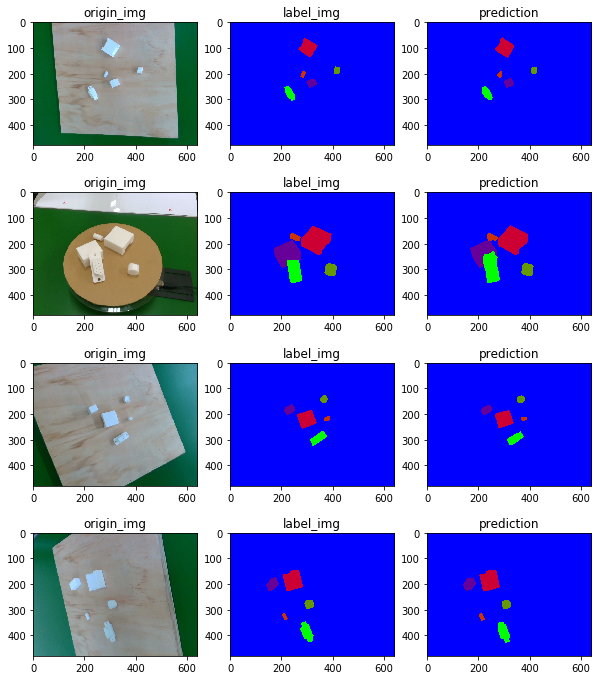

In [59]:
model =  'FCNs_' + model_use + '_batch' + str(batch_size) + '_epoch' + str(400-1) + '_RMSprop_lr0.0001.pkl'
# model = data_dir + '/models/' + 'FCNs_' + model_use + '_batch' + str(batch_size) + '_epoch' + '9' + '_RMSprop_lr0.0001.pkl'

# model = os.path.join('ele_499epoch.pkl')
# model = fcn_model
print model

prediction(model)

### HW: Plot three graphs: Training loss, class IOU curve, class F-score curve  

In [62]:
def draw_evaluation_curve(
    score_dir_path = score_dir, 
    f_score_filename="fscore_log.txt", 
    cls_iou_filename="cls_iou_log.txt", 
    loss_filename="loss_log.txt"):
    
    epoch = np.arange(0,600,1)
    color = ['red', 'green', 'blue', 'yellow', 'brown']
    brand = ['cuboid','cube','cylinder','flat_cylinder','polyhedron']
    
    plt.figure()
    for i in range(len(brand)):
        plt.title("fscore")
        plt.plot(epoch, np.array(fscore_l)[:,i], color = color[i], label = brand[i])
        plt.legend()
#     plt.xlim(0,100)
    plt.figure()
    for i in range(len(brand)):
        plt.title("iou")
        plt.plot(epoch, np.array(iou_l)[:,i], color = color[i], label = brand[i])
        plt.legend()
#     plt.xlim(0,100)
    plt.figure()
    plt.title("loss")
    plt.plot(epoch, loss_l, color = 'black', label = 'loss')
    plt.legend()
#     plt.xlim(0,100)

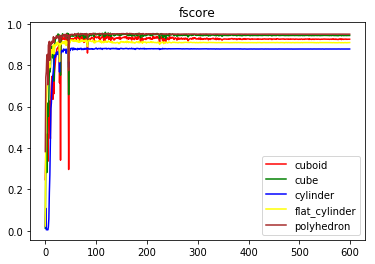

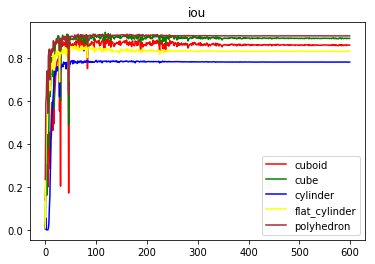

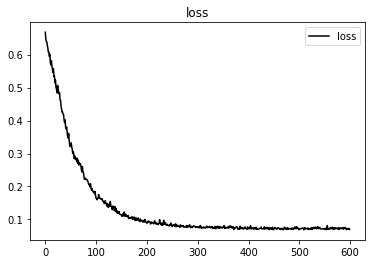

In [63]:
draw_evaluation_curve()

## TEST


In [18]:
# data_path = "./electronics_test"

# test_file = os.path.join(data_dir, "test.csv")
# test_data   = product_dataset(csv_file = test_file, phase = 'test', flip_rate = 0)
# test_loader = DataLoader(test_data, batch_size = 4, num_workers = 0)
# dataiter = iter(test_loader)

# print (test_file)

In [19]:
# def test(model_name, data_path):
#     state_dict = torch.load(os.path.join(model_dir, model_name))
#     fcn_model.load_state_dict(state_dict)
#     img        = cv2.imread(data_path,cv2.IMREAD_UNCHANGED)
#     origin     = img
#     img        = img[:, :, ::-1]  # switch to BGR

#     img = np.transpose(img, (2, 0, 1)) / 255.
#     img[0] -= means[0]
#     img[1] -= means[1]
#     img[2] -= means[2]

#     # convert to tensor
#     img = img[np.newaxis,:]
#     img = torch.from_numpy(img.copy()).float() 
#     with torch.no_grad():
#         output = fcn_model(img)
#         output = output.data.cpu().numpy()

#     N, _, h, w = output.shape
#     pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

#     # show images
    
#     img = img.numpy()
#     for i in range(N):
#         plt.figure()
#         origin = cv2.cvtColor(origin, cv2.COLOR_BGR2RGB)
#         plt.title("origin_img")
#         plt.imshow(origin)
#         plt.figure()
#         plt.title("prediction")
#         plt.imshow(pred[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

#     plt.show()

In [20]:
#test("ele_499epoch.pkl","/home/allen/sis_mini_competition_2018/electronics_train/image/scene_0/pic_0.jpg")

In [64]:
def test():
    fcn_model.eval()
    TP_test = np.zeros(n_class-1)
    FN_test = np.zeros(n_class-1)
    FP_test = np.zeros(n_class-1)
    total_ious = []
    pixel_accs = []
    for iter, batch in enumerate(test_loader):
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
        else:
            inputs = Variable(batch['X'])

        with torch.no_grad():
            output = fcn_model(inputs)
            output = output.data.cpu().numpy()

        N, _, h, w = output.shape
        pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)

        target = batch['l'].cpu().numpy().reshape(N, h, w)
        for p, t in zip(pred, target):
            pixel_accs.append(pixel_acc(p, t))
            _TP, _FN, _FP =  analysis(p, t, h, w)
            TP_test += _TP[1:n_class]
            FN_test += _FN[1:n_class]
            FP_test += _FP[1:n_class]
            
    recall = TP_test / (TP_test + FN_test)
    precision = TP_test / (TP_test + FP_test)
    ious = TP_test / (TP_test + FN_test + FP_test)
    fscore = 2*TP_test / (2*TP_test + FN_test + FP_test)
    total_ious = np.array(total_ious).T  # n_class * test_len
    pixel_accs = np.array(pixel_accs).mean()
    
    print("pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
          .format(pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
#     iou_l.append(ious)
#     fscore_l.append(fscore)
    f1 = open(ele_test_dir + "/cls_acc_log.txt","a+")
    f1.write('pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(ele_test_dir + "/cls_iou_log.txt","a+")
    f2.write('class ious: ' + str(ious) + '\n' )
    f3 = open(ele_test_dir + "/mean_iou_log.txt","a+")
    f3.write('mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(ele_test_dir + "/recall_log.txt","a+")
    f4.write('class recall: ' + str(recall) + '\n' )
    f5 = open(ele_test_dir + "/precision_log.txt","a+")
    f5.write('class precision: ' + str(precision) + '\n' )    
    f6 = open(ele_test_dir + "/fscore_log.txt","a+")
    f6.write('class fscore: ' + str(fscore) + '\n' )  
    


In [65]:
test()

pix_acc: 0.0, meanIoU: 0.837520525349, IoUs: [0.7992027  0.83737266 0.81648241 0.83691059 0.89763428], recall: [0.91894598 0.89405564 0.88846002 0.87785006 0.95563717], precision: [0.85981286 0.92961615 0.90973344 0.9472172  0.93666531], fscore: [0.88839651 0.91148919 0.89897089 0.91121538 0.94605614]
